In [1]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

import codecs
import csv
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline



c:\users\parksoyoung\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\parksoyoung\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\parksoyoung\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c

In [2]:
origin = pd.read_csv('AFSNT.csv', encoding="cp949")
origin.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP1,ARP3,A,A1901,SEw3Nzc2,D,N,6:10,6:18,N,NaN,N,NaN
1,2017,1,1,일,ARP1,ARP3,A,A1905,SEw4MjM2,D,N,6:15,6:25,N,NaN,N,NaN
2,2017,1,1,일,ARP1,ARP3,L,L1751,SEw4MjM3,D,N,6:20,6:30,N,NaN,N,NaN
3,2017,1,1,일,ARP1,ARP3,F,F1201,SEw4MjA3,D,N,6:25,6:34,N,NaN,N,NaN
4,2017,1,1,일,ARP3,ARP1,A,A1900,SEw3NzAz,D,N,6:30,6:37,N,NaN,N,NaN


In [3]:
origin.rename(columns={'SDT_YY':'Year', 'SDT_MM':'Month', 'SDT_DD':'DAY'}, inplace=True)
#### 'STT'의 시간단위만 추출해 'hour'에 저장
origin['hour']=pd.to_datetime(origin['STT'],format= '%H:%M').dt.hour

####'SDT_DY'를 categorical 데이터로 수정
one_hot_dy = pd.get_dummies(origin['SDT_DY'])
origin = origin.drop(['SDT_DY'],axis = 1)
origin = origin.join(one_hot_dy)
origin.rename(columns={"일":"Sun","월":"Mon","화":"Tue","수":"Wed","목":"Thu","금":"Fri","토":"SAT","일":"Sun"                    
                  }, inplace=True)

In [4]:
#### 한 자리수 데이터를 앞에 '0'을 붙여 두 자리로 변환
def changeDate(data):
    data=str(data)
    if len(data)==1:
        data="0"+data
    return data

In [5]:
####군공항을 제외한 날씨 데이터를 다운받는 함수(공항공사 데이터)

def downloadAirport(yy,mm,area):
    mm=changeDate(mm)
    yy=str(yy)
    url='http://amoapi.kma.go.kr/amoApi/air_stcs?icao='+area+'&yyyymm='+yy+mm
    response = urllib.request.urlopen(url)
    cr = csv.reader(codecs.iterdecode(response, 'utf-8'))
    
    #### url로 읽어와 데이터 프레임에 저장
    temp=[]
    for line in cr:
        temp.append(line)
    
    labels=temp[0]
    weather=pd.DataFrame.from_records(temp[1:],columns=labels)
    
    weather["TM"]=weather["TM"].astype("str")

    weather["Year"]=weather["TM"].str.slice(0,4)
    weather["Month"]=weather["TM"].str.slice(4,6)
    weather["DAY"]=weather["TM"].str.slice(6,8)
    hh=weather["TM"].str.slice(8,10)
    weather['hour']=hh

    weather['hour']= weather['hour'].astype('int')
    weather['hour']=weather['hour'].replace(24,0)
    
    #### 분석에 필요하지 않은 column 삭제
    weather.drop(columns=["TM"], axis=1, inplace=True)
    weather.drop(columns=["WD","WS_GST","RVR1","RVR2","RVR3","RVR4","CLA_1LYR"
               ,"BASE_1LYR","CLF_1LYR","CLA_2LYR","BASE_2LYR","CLF_2LYR",
               "CLA_3LYR","BASE_3LYR","CLF_3LYR","CLA_4LYR","BASE_4LYR","CLF_4LYR"], axis=1, inplace=True)
    
    
    #### 기록이 안 되어 있는 데이터에 '0'을 채워줌
    weather=weather.fillna(0)
    weather["Year"]=weather["Year"].astype("int")
    weather["Month"]=weather["Month"].astype("int")
    weather["DAY"]=weather["DAY"].astype("int")
    
    return weather 

In [6]:
#### 항공데이터에서 제공하지 않는 군공항 데이터를 기상청 날씨데이터를 사용해 다운받는 함수(기상청 csv)
def downloadWeather(year):
    filename="data/"+str(year)+".csv"
    weather=pd.read_csv(filename,encoding="cp949")
    
    #### 일시의 데이트타입과 시간을 따로 저장
    weather["일시"] = weather["일시"].astype('str')
    date=weather["일시"].str.split(expand=True)
    day=date[0].str.split("-",expand=True)
    
    weather["Year"]=day[0]
    weather["Month"]=day[1]
    weather["DAY"]=day[2]
    
    
    weather["hour"]=date[1]
    
    #### 일시 drop(변경 전 데이터)
    weather.drop(columns=['일시'], axis=1, inplace=True)
    #### 분석에 필요하지 않은 column 삭제
    weather = weather.drop(['지면온도(°C)',"지면온도 QC플래그","5cm 지중온도(°C)","10cm 지중온도(°C)","20cm 지중온도(°C)","기온 QC플래그",
                            "강수량 QC플래그","풍속 QC플래그","풍향(16방위)","풍향 QC플래그","습도 QC플래그","현지기압 QC플래그",
                            "해면기압 QC플래그","중하층운량(10분위)","운형(운형약어)","최저운고(100m )","지면상태(지면상태코드)",
                           "적설(cm)","3시간신적설(cm)", "30cm 지중온도(°C)","일조(hr)","일조 QC플래그","일사(MJ/m2)"],axis = 1)
    
    #### 한글을 사용함으로써 발생하는 오류를 방지하기 위해 column명들을 영어로 rename
    weather.rename(columns={"지점" : "area", "기온(°C)":"temp" ,"강수량(mm)":"rain", "풍속(m/s)":"windSpeed",
                            "습도(%)":"hum","증기압(hPa)":"Vapor","이슬점온도(°C)":"dew","현지기압(hPa)":"hpa",
                            "해면기압(hPa)":"seeHpa","시정(10m)":"visible","전운량(10분위)":"cloudTotal",
                            "현상번호(국내식)":"weatherCode"}, inplace=True)
    
    #### merge시에 타입이 같아야 하므로 데이터타입을 int형으로 변환
    weather["hour"]=weather["hour"].astype("str")
    weather["hour"]=weather["hour"].str.split(":",expand=True)[0]
    weather["hour"]=weather["hour"].astype("int")
    
    weather["Year"]=weather["Year"].astype("int")
    weather["Month"]=weather["Month"].astype("int")
    weather["DAY"]=weather["DAY"].astype("int")
    
    #### 기록이 안 되어 있는 데이터에 '0'을 채워줌    
    weather=weather.fillna(0)
    return weather

In [7]:
#### 군공항을 제외한 항공들의 날씨 데이터와 기상 정보를 merge하는 함수
def mergeAirportData():
    df_all=pd.DataFrame()
    #### 군공항을 제외한 항공들만 저장
    temp=origin[(origin.ARP=="ARP1") | (origin.ARP=="ARP3")| (origin.ARP=="ARP5") | (origin.ARP=="ARP7") 
                | (origin.ARP=="ARP9")| (origin.ARP=="ARP10") ]
    
    elements,count=np.unique(temp["ARP"],return_counts=True)
    
    #### 각각의 공항에 대하여 월별로 데이터를 찾아 merge하고 DataFrame형태로 저장하는 loop문
    for i in range(len(elements)):
        df_areaD=pd.DataFrame()
        arp=elements[i]
        area={"ARP1":"RKSS","ARP3":"RKPC","ARP5":"RKPU",
              "ARP7":"RKJB","ARP9":"RKJY","ARP10":"RKNY"}.get(arp)
        df_areaD=temp[temp["ARP"]==arp]
        
        for j in range(3):
            year=2017+j
            for k in range(12):
                #### 2019년은 데이터가 6월까지만 존재함
                if year==2019:
                    if k>=6:
                        break;
                month=1+k
                df_date=df_areaD[(df_areaD["Year"]==year) & (df_areaD["Month"]==month)]
                weather=downloadAirport(year,month,area)
                df_new=pd.merge(df_areaD,weather,on=["Year","Month","DAY","hour"])
                
                if i==0 and j==0 and k==0:
                    df_all=df_new.copy()
                else:
                    df_all=df_all.append(df_new)
                    
    #### 기상청데이터와 연결 하기 위해 rename                
    df_all.rename(columns={'WSPD':'windSpeed','VIS':"visible","TMP":"temp",
                      "TD":"dew",'PS':'hpa','PA':'seeHpa','RN':'rain','HM':'hum',
                        'CA_TOT':'cloudTotal','WC':"weatherCode"}, inplace=True)
    
    
    #### 기상청에서 받아온 파일과 함께 저장하기 위해 항공공사의 데이터의 단위를 조정함
    df_all['temp']=df_all['temp'].astype("float")/10
    df_all['hpa']=df_all['hpa'].astype("float")/10
    df_all['seeHpa']=df_all['seeHpa'].astype("float")/10
    df_all['dew']=df_all['dew'].astype("float")/10
    df_all['windSpeed']=df_all['windSpeed'].astype("float")*1852/3600
    
    return df_all

In [8]:
#### 군공항에 대해 기상청을 통해 불러온 날씨 데이터와 기상 정보를 merge하는 함수
def mergeWeatherData():
    temp=origin[(origin.ARP=="ARP2") | (origin.ARP=="ARP4")| (origin.ARP=="ARP6") | (origin.ARP=="ARP8") | (origin.ARP=="ARP11")
                | (origin.ARP=="ARP12")| (origin.ARP=="ARP13")| (origin.ARP=="ARP14")|(origin.ARP=="ARP15")]
    
    elements,count=np.unique(temp["ARP"],return_counts=True)
    
    #### 각각의 공항에 대하여 연별로 데이터를 찾아 merge하고 저장하는 loop문
    for i in range(3):
        df_areaD=pd.DataFrame()
        year=2017+i
        weather=downloadWeather(year)
        df_yearD=origin[origin["Year"]==year]
        for j in range(len(elements)):
            arp=elements[j]
            area={"ARP2":159,"ARP4":143,"ARP6":131, "ARP8":156,
                  "ARP11":138,"ARP12":192, "ARP13":140,"ARP14":114,"ARP15":112}.get(arp)
            
            df_areaD=df_yearD[df_yearD["ARP"]==arp]
            df_new=pd.DataFrame()
            weatherT=weather[weather["area"]==area]
           
            df_new=pd.merge(df_areaD,weatherT,on=["DAY","hour","Year","Month"])
        
            if i==0 and j==0:
                df_all=df_new.copy()
            else:
                df_all=df_all.append(df_new)
    return df_all

In [9]:
df_airport=mergeAirportData()
df_nonAirport=mergeWeatherData()

df_weather=df_airport.append(df_nonAirport)

In [10]:
df_weather.drop(['area','Vapor', 'hour'], axis = 1, inplace=True)
#### 데이터가 입력되어있지 않은 것들을 '0'으로 대체함
df_weather['visible']= df_weather['visible'].replace("", 0)
df_weather['hum']= df_weather['hum'].replace("", 0)

In [11]:
#### 기상정보와 날씨 데이터를 합친 DataFrame을 파일로 저장
df_weather.to_csv("weatherFinal.csv",index=False)

In [12]:
############################################################

In [13]:
# read 데이터
df = pd.read_csv('weatherFinal.CSV', encoding="cp949")
df.head()

,AOD,ARP,ATT,CNL,CNR,DAY,DLY,DRR,FLO,FLT,...,cloudTotal,dew,hpa,hum,rain,seeHpa,temp,visible,weatherCode,windSpeed
0,D,ARP1,6:18,N,NaN,1,N,NaN,A,A1901,...,3.0,-5.7,1029.0,80.0,NaN,1027.4,-2.5,250.0,10.0,1.543333
1,D,ARP1,6:25,N,NaN,1,N,NaN,A,A1905,...,3.0,-5.7,1029.0,80.0,NaN,1027.4,-2.5,250.0,10.0,1.543333
2,D,ARP1,6:30,N,NaN,1,N,NaN,L,L1751,...,3.0,-5.7,1029.0,80.0,NaN,1027.4,-2.5,250.0,10.0,1.543333
3,D,ARP1,6:34,N,NaN,1,N,NaN,F,F1201,...,3.0,-5.7,1029.0,80.0,NaN,1027.4,-2.5,250.0,10.0,1.543333
4,D,ARP1,6:38,N,NaN,1,N,NaN,H,H1101,...,3.0,-5.7,1029.0,80.0,NaN,1027.4,-2.5,250.0,10.0,1.543333


In [14]:
df = df[df.IRR != "Y"] # 부정기 없애기 
df = df[df.CNL != "Y"]

# 비행기 취소와 관련된 Column 삭제
df.drop(columns=['CNL', 'CNR'], axis=1, inplace=True)

# 사용되지 않을 것 같은 데이터 일단 삭제
df.drop(columns=['REG', 'IRR'], axis=1, inplace=True)

# 딜레이 이유 (나중에 쓰일 듯)
df.drop(columns=['DRR'], axis=1, inplace=True)

############# 날씨 데이터 추가 후 주석 제거할 것.
# 날씨 관련 안쓰는 feature 삭제
df.drop(columns=['rain', 'weatherCode'], axis=1, inplace=True)


In [15]:
# ATT (actual time data)가 널 값인 레코드 삭제
df = df[pd.notnull(df['ATT'])]
df.isnull().sum()

AOD           0
ARP           0
ATT           0
DAY           0
DLY           0
FLO           0
FLT           0
Fri           0
Mon           0
Month         0
ODP           0
SAT           0
STT           0
Sun           0
Thu           0
Tue           0
Wed           0
Year          0
cloudTotal    0
dew           0
hpa           0
hum           0
seeHpa        0
temp          0
visible       0
windSpeed     0
dtype: int64

In [16]:
# ARP와 ODP가 같은 데이터 --> Wrong data => 삭제
df.drop(df[df['ARP'] == df['ODP']].index, inplace=True)


In [17]:
#--------------- fog 모델 돌리기 --------------

## INPUT : 'temp', 'hum', 'dew', 'windSpeed' 4가지 Column의 DataFrame
from sklearn.preprocessing import MinMaxScaler

def fogPreProcessing (df):
    # 비어있는 값 0으로 대체
    #print(df.isnull().sum())
    df.fillna(0, inplace = True)
  
    # MinMaxScaling
    scaler = MinMaxScaler()
    df[['hum', 'dew','temp','windSpeed']] = scaler.fit_transform(df[['hum', 'dew','temp','windSpeed']])
  
    return df



In [18]:
fog = df[["temp","hum","dew","windSpeed"]]

fog = fogPreProcessing(fog)

In [19]:
import pickle
from sklearn.externals import joblib

# 저장된 모델 불러오기
clf_from_joblib = joblib.load('fogmodel.pkl') 

# 저장된 모델로 예측하기
#clf_from_joblib.predict(fog)

In [20]:
# 예측할 때 확률로가져오기!
result = clf_from_joblib.predict_proba(fog)

fog_column = []

# fog_column에 확률값 저장
for i in result:
    fog_column.append(i[1])
    
print("fog_column :",len(fog_column))

fog_column : 958150


In [21]:
df['fog'] = fog_column

df.drop(columns=['hum', 'dew','temp','windSpeed'], axis=1, inplace=True)
#------------------------------------------------------------

In [22]:
# ARP 경로 파생변수 생성
df['ARPODP'] = df['ARP'] + '_' + df['ODP']

In [23]:
from datetime import datetime, date

df['Diff'] = (pd.to_datetime(df['ATT'],format= '%H:%M') - pd.to_datetime(df['STT'],format= '%H:%M')).dt.seconds.astype('int64')

# STT와 ATT 격차 큰 순대로 정렬
df = df.sort_values(by=['Diff'], ascending=False)

########################################################################출발
# 딜레이가 최대 5시간이라고 가정했을 때, --> 즉, 2시간 초과한 딜레이는 wrong값이라 가정
max_delay_hour = 5
max_delay = max_delay_hour * 3600 # seconds

# 출발비행기의 경우, 조금이라도 출발이 빠른 건 wrong data라 판단.
# 7200보다 큰 값을 가지는 Diff 데이터 wrong 값 처리
df = df[((df['Diff'] <= max_delay) & (df['AOD']=='D')) | (df['AOD']=='A')]


########################################################################도착
#이정도는 늦게 도착해도 O
#2시간은 예상보다 늦게도착할 수 있다. 그 이상은 말이안된다
max_delay_hour_arr = 5
max_delay_arr = max_delay_hour_arr * 3600 # seconds

#몇분 일찍도착해도 O
#30분은 예상보다 빨리도착할 수 있음. 그거보다 빨리도착하는 건 말이 안됨
min_delay = 30*60
min_delay = 86400 - min_delay  # 86400(24시간)보다 위인거만 살려놓기
df = df[(df['AOD']=='D') |((df['Diff'] <= max_delay_arr) & (df['AOD']=='A')) | ((df['AOD']=='A')& (df['Diff'] >= min_delay )) ]
df.loc[df['Diff'] >=min_delay, 'Diff'] = df.loc[df['Diff'] >=min_delay, 'Diff']  - 86400


In [24]:
# 시간 + 분 합침.
df['ATT']= (pd.to_datetime(df['ATT'],format= '%H:%M').dt.hour).astype(str) + (pd.to_datetime(df['ATT'],format= '%H:%M').dt.minute).astype(str)
df['time']= (pd.to_datetime(df['STT'],format= '%H:%M').dt.hour).astype(str) + (pd.to_datetime(df['STT'],format= '%H:%M').dt.minute).astype(str)



df.drop(['FLT'], axis=1, inplace = True)
#날짜 년, 일 제거
df.drop(['DAY'], axis=1, inplace = True)

df.drop(['ATT','STT','Diff'], axis = 1, inplace=True)


In [25]:
df['time']= df['time'].astype('int')
scaler = MinMaxScaler()
df[['time']] = scaler.fit_transform(df[['time']])


In [26]:
# Target 레이블링

from sklearn import preprocessing
# DLY도 1과 0으로 데이터 처리
le = preprocessing.LabelEncoder()
df[['DLY']] = le.fit_transform(df[['DLY']])
df[['ARP']] = le.fit_transform(df[['ARP']])
df[['ODP']] = le.fit_transform(df[['ODP']])
df[['FLO']] = le.fit_transform(df[['FLO']])
df[['ARPODP']] = le.fit_transform(df[['ARPODP']])

In [27]:
# 도착, 출발 데이터 분리
df_A = df[df['AOD']=='A']
df_D = df[df['AOD']=='D']

# AOD column삭제 
df_A = df_A.drop(['AOD'],axis = 1)
df_D = df_D.drop(['AOD'],axis = 1)


In [28]:
def makeTestSet(df):
    X = df.drop(['DLY'], axis = 1)
    y = df['DLY']
        
    X_tr, X_t, y_tr, y_t = train_test_split(X,y, test_size= 0.3, random_state = 42)
    
    print("X_train set--------------------")
    print("Shape:",X_tr.shape)
    print("Target:")
    print(y_tr.value_counts())
    print()
      
    print("X_test set info-----------------")
    print("Shape:",X_t.shape)
    print("Target:")
    print(y_t.value_counts())
    print()

    return [X_tr, X_t, y_tr, y_t]

X_train_A, X_test_A, y_train_A, y_test_A = makeTestSet(df_A)
X_train_D, X_test_D, y_train_D, y_test_D = makeTestSet(df_D)

X_train set--------------------
Shape: (334954, 19)
Target:
0    312690
1     22264
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (143553, 19)
Target:
0    134013
1      9540
Name: DLY, dtype: int64

X_train set--------------------
Shape: (334481, 19)
Target:
0    275913
1     58568
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (143350, 19)
Target:
0    118180
1     25170
Name: DLY, dtype: int64



In [29]:
# ROC Curve그리기
def plot_roc_curve(fpr, tpr):
    
    
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [30]:
def confusion_matrix_heatmap(y_true, y_pred):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [31]:
def runModel (X_train, y_train, X_test, y_test, base = True):
    
    #X_train, y_train = under_sampling(X_train, y_train)
    
    
    
    models = []
    
    if base ==True:
          models.append(('XGB', XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                        silent=True, nthread=1,subsample=1.0,min_child_weight=5,max_depth=5,gamma=5,colsample_bytree=0.6)))
    
    # 평가
    results = []
    names = []
    scoring = 'recall'

    seed = 7
    for name, model in models:

        model.fit(X_train, y_train)
        y_predict = pd.Series(model.predict(X_test))

        # Resets index to compare original test data with predicted data
        y_test = y_test.reset_index(drop=True)
        y_predict = y_predict.reset_index(drop=True)


        print(model.score(X_test, y_test))
        print('-' * 50)
        
        #--------ROC Curve-----------------
        probs = model.predict_proba(X_test)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.2f' % auc)
        
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        plot_roc_curve(fpr, tpr)
        #-----------------------------------
        
        #-------- Confusion matrix heatmap -----------------
        confusion_matrix_heatmap(y_test, y_predict)
        print(classification_report(y_test, y_predict))
        #-----------------------------------
        
    
    return

0.9341776208090392
--------------------------------------------------
AUC: 0.75


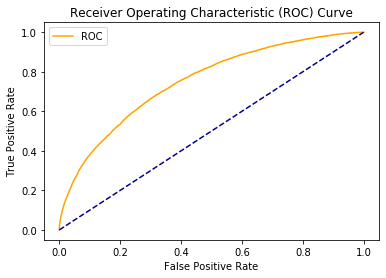

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    134013
           1       0.75      0.01      0.03      9540

    accuracy                           0.93    143553
   macro avg       0.84      0.51      0.50    143553
weighted avg       0.92      0.93      0.90    143553



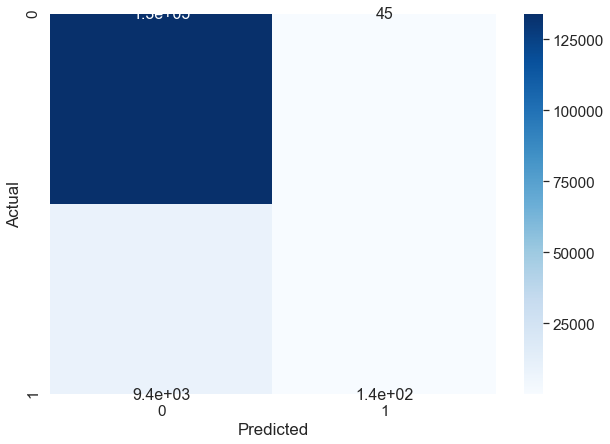

In [32]:
runModel (X_train_A,y_train_A, X_test_A, y_test_A, True)

0.8280502267178235
--------------------------------------------------
AUC: 0.73


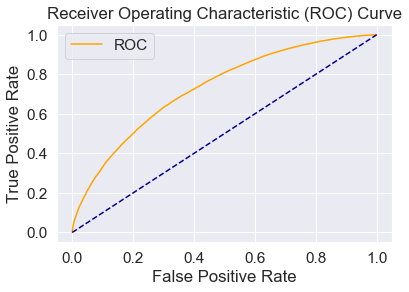

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    118180
           1       0.72      0.03      0.06     25170

    accuracy                           0.83    143350
   macro avg       0.77      0.52      0.49    143350
weighted avg       0.81      0.83      0.76    143350



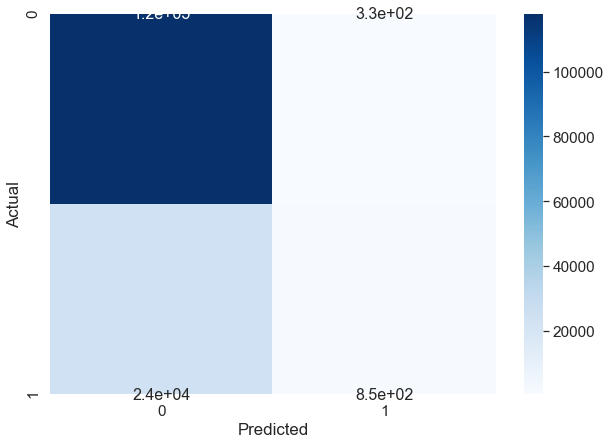

In [33]:
runModel (X_train_D,y_train_D, X_test_D, y_test_D, True)